In [2]:
%pip install pandas numpy matplotlib scikit-learn keras tensorflow-macos tensorflow-metal prometheus-api-client

  Using cached tensorflow-2.16.2-cp311-cp311-macosx_12_0_arm64.whl.metadata (4.1 kB)
Using cached tensorflow-2.16.2-cp311-cp311-macosx_12_0_arm64.whl (227.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf

# Verificar se o TensorFlow consegue detectar a GPU
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow está utilizando a GPU")
else:
    print("TensorFlow não está utilizando a GPU. Verifique a instalação do CUDA/cuDNN.")


TensorFlow está utilizando a GPU


In [4]:
import tensorflow as tf

# Verificar se o TensorFlow está utilizando a GPU
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt

In [11]:
# Load the time series data
metric_df = pd.read_pickle("../data/ts.pkl")

# Resample the data to 30-minute intervals
ts = metric_df["value"].astype(float).resample("30min").mean()

# Split the data into train and test sets
train = ts[:"2021-02-07"]
test = ts["2021-02-08":]

In [12]:
# Scale the data using a MinMaxScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

In [13]:
# Define the number of time steps and features
n_steps = 40
n_features = 1

# Create sequences of input data and target values for train set
X_train, y_train = [], []
for i in range(n_steps, len(train_scaled)):
    X_train.append(train_scaled[i-n_steps:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data to be 3D
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))

# Number of times to train the model
num_iterations = 20

# List to store metrics
rmse_list = []
mae_list = []
test_preds = []
train_preds = []  # Step 1: Create a list to store the predicted train values for each iteration.
mse_list = []
r2_list = []


In [14]:
# Loop to train the model multiple times
for i in range(num_iterations):
    # Define the RNN model architecture
    model = Sequential()
    model.add(LSTM(100, activation='tanh', input_shape=(n_steps, n_features), return_sequences=True))
    model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
    model.add(LSTM(100, activation='tanh'))  # Second LSTM layer
    model.add(Dropout(0.2))  # Another Dropout layer
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mse') 

    # Train the model
    model.fit(X_train, y_train, epochs=50, verbose=0)

    # Create sequences of input data and target values for test set
    X_test, y_test = [], []
    for j in range(n_steps, len(test_scaled)):
        X_test.append(test_scaled[j-n_steps:j, 0])
        y_test.append(test_scaled[j, 0])
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Reshape the input data to be 3D
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_features))

    # Make predictions on the test set
    test_pred = model.predict(X_test)
    test_pred = scaler.inverse_transform(test_pred)
    test_preds.append(test_pred)

    # Make predictions on the train set
    train_pred = model.predict(X_train)
    train_pred = scaler.inverse_transform(train_pred)
    train_preds.append(train_pred)

    # Evaluate the model on the test set and store metrics
    rmse = np.sqrt(np.mean((test_pred - test.values)**2))
    rmse_list.append(rmse)
    mae = mean_absolute_error(test.values[n_steps:], test_pred)
    mae_list.append(mae)

    # Calculate MSE and R-squared
    mse = mean_squared_error(test.values[n_steps:], test_pred)
    mse_list.append(mse)
    
    r2 = r2_score(test.values[n_steps:], test_pred)
    r2_list.append(r2)

    # Print metrics for each iteration
    print(f"Iteration {i + 1} - RMSE: {rmse}, MAE: {mae}, MSE: {mse}, R-squared: {r2}")


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Iteration 1 - RMSE: 91161657.25482799, MAE: 24294076.128395073, MSE: 1439077321390840.2, R-squared: 0.6734558984623821


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Iteration 2 - RMSE: 92450821.76482384, MAE: 20536668.602469146, MSE: 1416032674468155.0, R-squared: 0.6786850084016223


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Iteration 3 - RMSE: 92281785.95820424, MAE: 24684978.962962978, MSE: 1843041220241571.8, R-squared: 0.5817915893644144


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Iteration 4 - RMSE: 93207912.46199974, MAE: 24154512.355555568, MSE: 1836824715705160.8, R-squared: 0.5832021896555684


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Iteration 5 - RMSE: 96613950.6838527, MAE: 28504580.740740757, MSE: 2427434616600178.0, R-squared: 0.4491856385083447


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Iteration 6 - RMSE: 92565427.59576069, MAE: 29206272.39506174, MSE: 2362013710073165.5, R-squared: 0.46403043581429715


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Iteration 7 - RMSE: 92182211.50938402, MAE: 26847976.296296313, MSE: 1889902460602658.0, R-squared: 0.5711582054571065


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Iteration 8 - RMSE: 93522256.4567182, MAE: 32474913.659259275, MSE: 2396016235344986.5, R-squared: 0.45631485034862806


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Iteration 9 - RMSE: 92074090.38804123, MAE: 24640417.501234576, MSE: 1787434507347722.0, R-squared: 0.5944094270799258


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Iteration 10 - RMSE: 91471523.62000673, MAE: 23589975.1506173, MSE: 1605440847338930.0, R-squared: 0.6357059962841968


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Iteration 11 - RMSE: 90098499.74515593, MAE: 28034980.582716063, MSE: 1754808776240390.5, R-squared: 0.6018126012479093


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Iteration 12 - RMSE: 94404609.74923578, MAE: 28184011.930864207, MSE: 2137045975253585.2, R-squared: 0.5150783439076672


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Iteration 13 - RMSE: 90066394.01209089, MAE: 22775382.676543217, MSE: 1454268135326946.8, R-squared: 0.6700089185019191


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Iteration 14 - RMSE: 89810249.78145464, MAE: 27121793.34320988, MSE: 1715724413954727.0, R-squared: 0.6106813171793144


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Iteration 15 - RMSE: 90345261.37494749, MAE: 21829558.43950618, MSE: 1362944619154451.5, R-squared: 0.690731332158596


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Iteration 16 - RMSE: 91394462.77979645, MAE: 25904628.2271605, MSE: 1907550083392567.0, R-squared: 0.5671537457643945


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Iteration 17 - RMSE: 95081283.29336691, MAE: 26779491.00246915, MSE: 1957482260320384.2, R-squared: 0.5558235290968474


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Iteration 18 - RMSE: 92422706.88190067, MAE: 23867116.800000012, MSE: 1563250361146549.5, R-squared: 0.6452795294101381


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Iteration 19 - RMSE: 91911082.9977935, MAE: 27089540.740740757, MSE: 1796681332787288.2, R-squared: 0.5923112102153031


/Users/wrosalem/Documents/0x0-Coding/GitHub/UNESP-Com_Inspirada-Artigo/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Iteration 20 - RMSE: 90574415.77621593, MAE: 29151096.098765448, MSE: 1917018229958551.8, R-squared: 0.5650053084513611


In [15]:
# Calculate the mean metrics
mean_rmse = np.mean(rmse_list)
mean_mae = np.mean(mae_list)
mean_mse = np.mean(mse_list)
mean_r2 = np.mean(r2_list)

print("Mean RMSE:", mean_rmse)
print("Mean MAE:", mean_mae)
print("Mean MSE:", mean_mse)
print("Mean R-squared:", mean_r2)

# Calculate the mean predicted train values
mean_train_preds = np.mean(train_preds, axis=0)

Mean RMSE: 92182030.20427889
Mean MAE: 25983598.581728406
Mean MSE: 1828499624832440.5
Mean R-squared: 0.5850912537654968


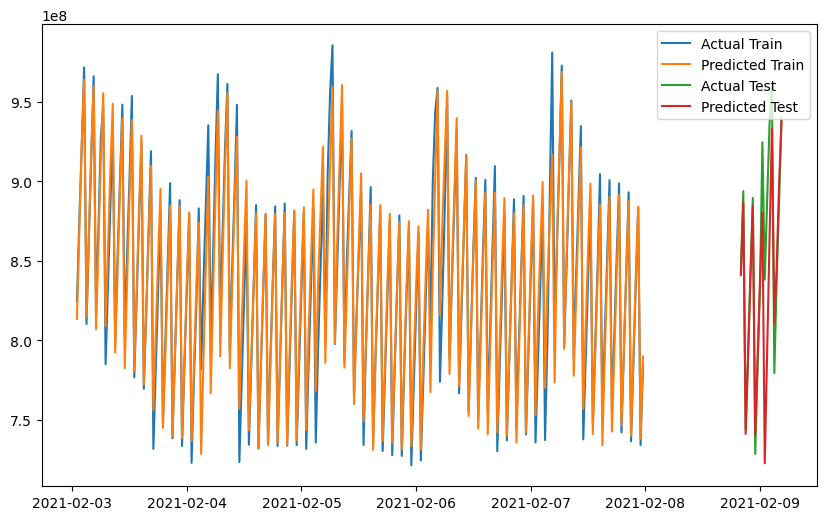

In [16]:
# Plot the actual vs predicted values for the train and test sets
plt.figure(figsize=(10, 6))
plt.plot(train.index[n_steps:], train.values[n_steps:], label="Actual Train")
plt.plot(train.index[n_steps:], mean_train_preds, label="Predicted Train")
plt.plot(test.index[n_steps:], test.values[n_steps:], label="Actual Test")
plt.plot(test.index[n_steps:], np.mean(test_preds, axis=0), label="Predicted Test")
plt.legend()
plt.show()